# Time Series Analysis - Inflation and BI Rate


**Bogor, 6th January 2024**


---

# Import Library - Dataset
---

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from collections import defaultdict
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import acf, pacf, ccf, VAR, adfuller, coint
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm

c:\users\aiforesee\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\aiforesee\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\aiforesee\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Load data csv
df = pd.read_csv("inflation_birate.csv", parse_dates = ["date"]).sort_values('date')
df

,date,inflation,birate
0,2009-01-01,9.17,8.75
1,2009-02-01,8.60,8.25
2,2009-03-01,7.92,7.75
3,2009-04-01,7.31,7.50
4,2009-05-01,6.04,7.25
...,...,...,...
173,2023-06-01,3.52,5.75
174,2023-07-01,3.08,5.75
175,2023-08-01,3.27,5.75
176,2023-09-01,2.28,5.75


# Data Preparation and Exploratory Data Analysis
---

## Data Info
---

In [3]:
# Cek data dengan tipe datetime
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       178 non-null    datetime64[ns]
 1   inflation  178 non-null    float64       
 2   birate     178 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 5.6 KB


In [4]:
# Set date sebagai index
df.set_index("date", inplace = True)

## Transformation
---

In [5]:
# Transformasi log untuk positive forecast
df["log_inflation"] = np.log(df["inflation"])
df["log_birate"] = np.log(df["birate"])

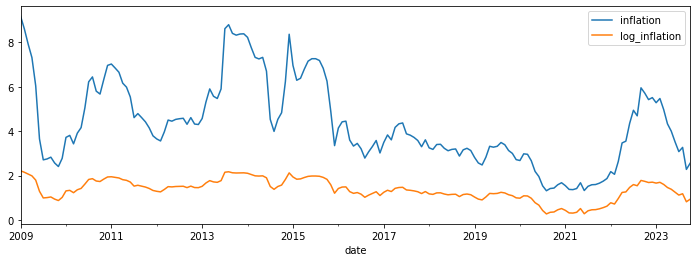

In [6]:
# Plot Inflasi
df["inflation"].plot(figsize = (12,4), legend = True)

# Plot log inflasi
df["log_inflation"].plot(figsize = (12,4), legend = True)

plt.show()

## Plot
---

### Time Plot
---

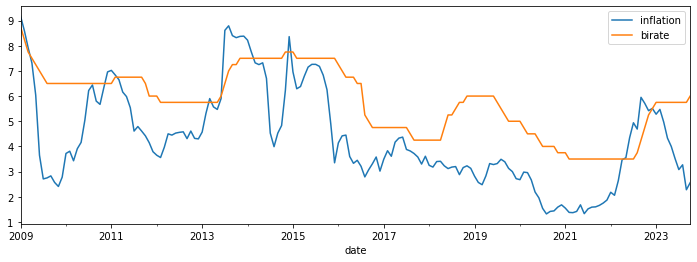

In [7]:
# Plot inflasi
df["inflation"].plot(figsize = (12,4), legend = True)

# Plot BI Rate
df["birate"].plot(figsize = (12,4), legend = True)

plt.show()

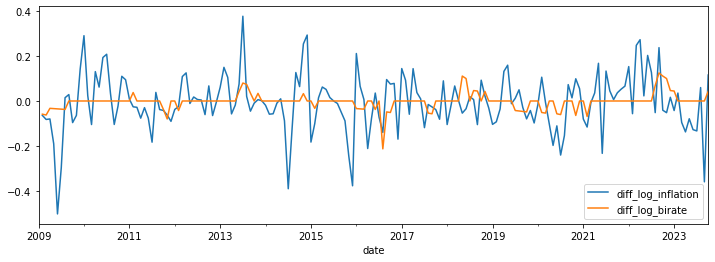

In [8]:
df['diff_log_inflation'] = np.log(df['inflation']).diff()
df['diff_log_birate'] = np.log(df['birate']).diff()

# Plot inflasi
df["diff_log_inflation"].plot(figsize = (12,4), legend = True)

# Plot BI Rate
df["diff_log_birate"].plot(figsize = (12,4), legend = True)

plt.show()

### Lag Plot
---

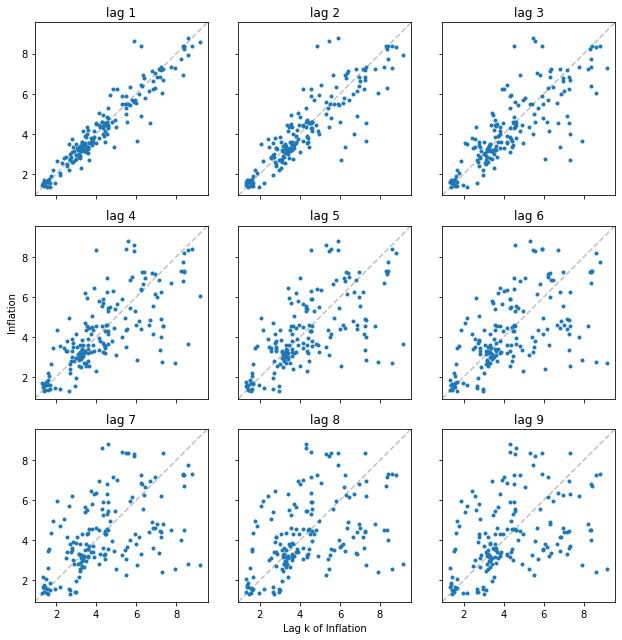

In [9]:
# Definisi lag pada inflasi
lag_ = pd.DataFrame({lag: df["inflation"].shift(lag) for lag in range(10)})

fig, axes = plt.subplots(nrows = 3, 
                         ncols = 3, 
                         figsize = (9,9), 
                         sharex = True, 
                         sharey = True)

# Iterasi ax 
for (i, ax) in enumerate(axes.ravel()):
    
    ax.plot(lag_[i+1], lag_[0], '.')
    lim = ax.get_xlim()
    ax.plot(lim, lim, 'k--', alpha = .25, zorder = -10)
    ax.set(xlim = lim, ylim = lim, title = f'lag {i+1}', aspect = 'equal')
    
axes.ravel()[3].set_ylabel("Inflation")
axes.ravel()[7].set_xlabel("Lag k of Inflation")
plt.tight_layout()

- Terdapat hubungan positif kuat yang teridentifikasi pada lag 1, 2 dan 3.
- Terdapat juga hubungan positif lemah yang terindikasi pada lag 4, 5, 6, 7, 8, dan 9.

### ACF, PACF,  CCF Plots

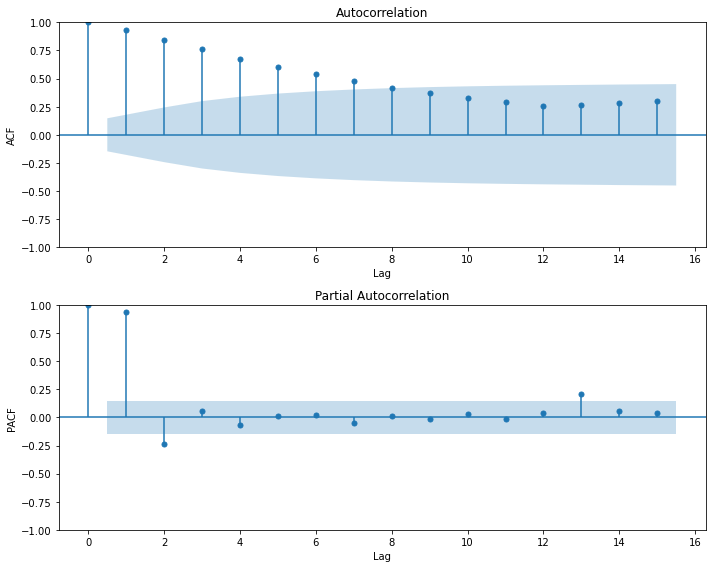

In [10]:
fig = plt.figure(figsize=(10, 8))

# Plot ACF
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df["inflation"], lags=15, ax=ax1)
plt.xlabel("Lag")
plt.ylabel("ACF")

# Plot PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df["inflation"], lags=15, ax=ax2)
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.tight_layout();
plt.show()

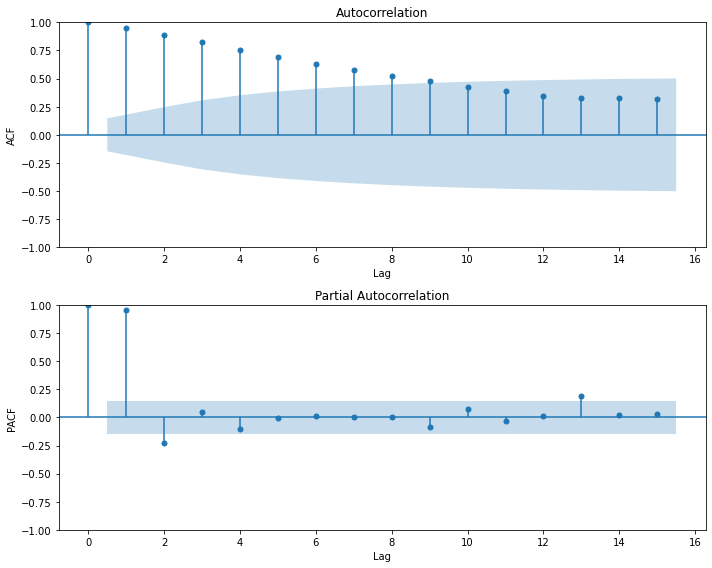

In [11]:
fig = plt.figure(figsize=(10, 8))

# Plot ACF
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df["log_inflation"].dropna(), lags=15, ax=ax1)
plt.xlabel("Lag")
plt.ylabel("ACF")

# Plot PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df["log_inflation"].dropna(), lags=15, ax=ax2)
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.tight_layout();
plt.show()

Pada ACF dan PACF Plot untuk initial dan log-transformed
- ACF menurun secara perlahan. Menyiratkan pola atau tren yang berkembang.
- Nilai autokorelasi positif yang besar biasanya diamati pada data non-stasioner

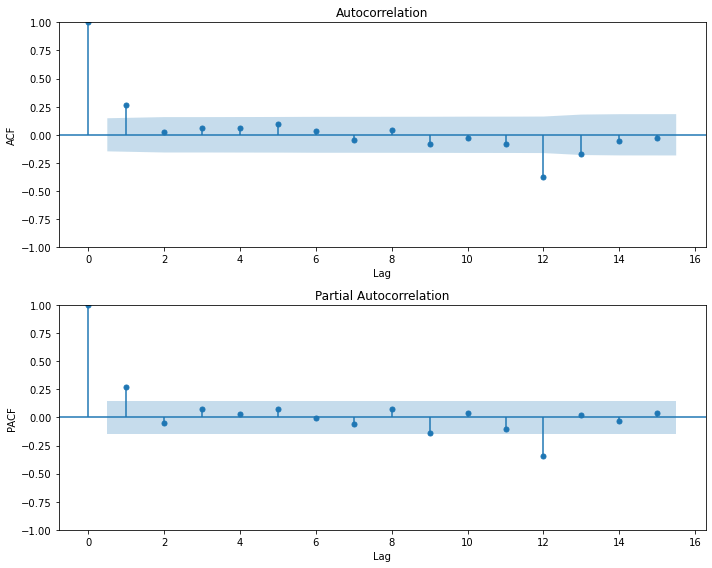

In [12]:
fig = plt.figure(figsize=(10, 8))

# Plot ACF
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df["diff_log_inflation"].dropna(), lags=15, ax=ax1)
plt.xlabel("Lag")
plt.ylabel("ACF")

# Plot PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df["diff_log_inflation"].dropna(), lags=15, ax=ax2)
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.tight_layout();
plt.show()

- ACF turun ke nol dengan cepat, menunjukkan tren yang stabil dan konsisten dari waktu ke waktu

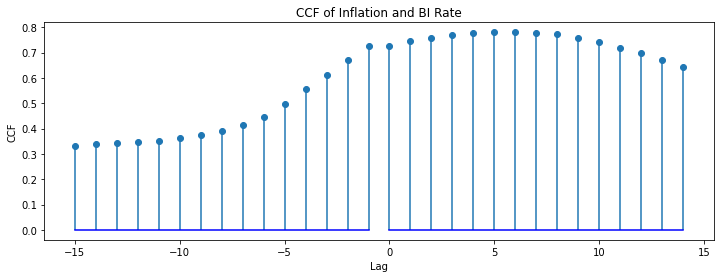

In [13]:
max_lag = 15

# Menghitung CCF
ccf_bi_inf = ccf(df["inflation"], df["birate"])[:max_lag]

# Menghitung CCF
ccf_inf_bi = ccf(df["birate"], df["inflation"])[:max_lag]

plt.figure(figsize=(12,4))

# Plot CCF
plt.stem(range(-max_lag,0), ccf_bi_inf[::-1], basefmt="b-")

# Plot CCF
plt.stem(range(max_lag), ccf_inf_bi, basefmt="b-")

plt.xlabel("Lag")
plt.ylabel("CCF")
plt.title("CCF of Inflation and BI Rate")
plt.show()

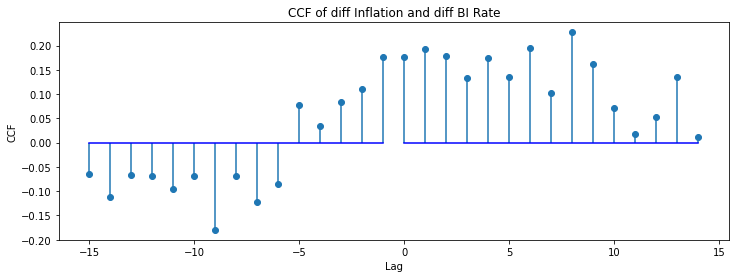

In [14]:
max_lag = 15

# Menghitung CCF
ccf_bi_inf = ccf(df["diff_log_inflation"].dropna(), df["diff_log_birate"].dropna())[:max_lag]

# Menghitung CCF
ccf_inf_bi = ccf(df["diff_log_birate"].dropna(), df["diff_log_inflation"].dropna())[:max_lag]

plt.figure(figsize=(12,4))

# Plot CCF
plt.stem(range(-max_lag,0), ccf_bi_inf[::-1], basefmt="b-")

# Plot CCF
plt.stem(range(max_lag), ccf_inf_bi, basefmt="b-")

plt.xlabel("Lag")
plt.ylabel("CCF")
plt.title("CCF of diff Inflation and diff BI Rate")
plt.show()

- CCF mencapai puncaknya pada h = -9 dengan hubungan korelasi bersifat negatif.
- Hal ini menunjukkan bahwa nilai BI Rate di atas rata-rata akan menyebabkan nilai inflasi di bawah rata-rata sekitar 9 bulan kemudian. Dan, nilai BI Rate di bawah rata-rata akan menyebabkan nilai inflasi di atas rata-rata sekitar 9 bulan kemudian.

### pairplot

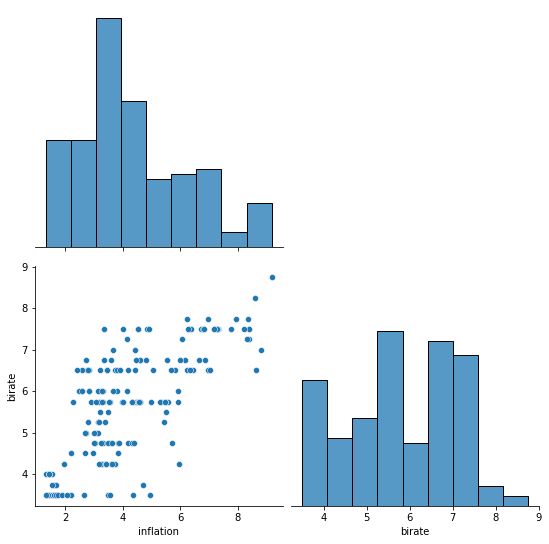

In [15]:
from matplotlib import rcParams

g = sns.pairplot(df[['inflation', 'birate']], corner=True)
g.fig.set_figwidth(8)
g.fig.set_figheight(8)

Dari plot diatas, terdapat hubugan positif yang kuat antara Inflasi dan BI Rate 

# Forecasting Modeling
---

## Check the Data Quality
---

In [16]:
# Cek missing values
pd.DataFrame(df[['inflation', 'birate']].isna().sum()).rename(columns = {0: 'missing value'})

,missing value
inflation,0
birate,0


In [17]:
# cek duplicate data
df.reset_index().duplicated(['date']).sum()

0

In [18]:
# Set 18 data observasi sebagai set testing
nobs_test = 18

# Split menjadi train dan test
df_train = df[:-nobs_test].copy()
df_test = df[-nobs_test:].copy()

# Cek ukuran dataframe
print(df_train.shape)
print(df_test.shape)

(160, 6)
(18, 6)


## Baseline Model: Naive Method
---

Pada naive forecast, meramalkan periode berikutnya sama dengan periode sebelumnya

In [19]:
# forecast dengan Naive Model
df_test['naive_forecast'] = df_train.loc['2022-04-01', 'inflation']

<AxesSubplot:xlabel='date'>

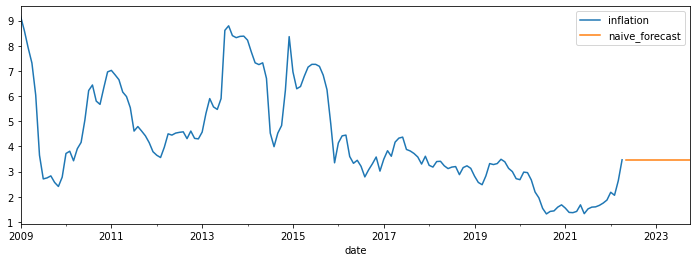

In [20]:
df_train["inflation"].plot(figsize = (12,4), legend=True)
df_test["naive_forecast"].plot(figsize = (12,4), legend=True)

In [21]:
# RMSE Naive Model
rmse_naive_model = np.sqrt(mse(df_test["inflation"], df_test["naive_forecast"]))
rmse_naive_model

1.424928848126187

## Univariate Time Series Model: ARIMA
---

### Order Selection
---

In [22]:
# Set parameter p dan q dengan value diantara 0 dan 3
p = q = range(0, 10)

# Set d = 1
d = [1]

# Generate semua kombinasi p, q dan d
pdq = list(itertools.product(p, d, q))
print(len(pdq))
pdq

100


[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 1, 6),
 (1, 1, 7),
 (1, 1, 8),
 (1, 1, 9),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (2, 1, 6),
 (2, 1, 7),
 (2, 1, 8),
 (2, 1, 9),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (3, 1, 6),
 (3, 1, 7),
 (3, 1, 8),
 (3, 1, 9),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (4, 1, 6),
 (4, 1, 7),
 (4, 1, 8),
 (4, 1, 9),
 (5, 1, 0),
 (5, 1, 1),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5),
 (5, 1, 6),
 (5, 1, 7),
 (5, 1, 8),
 (5, 1, 9),
 (6, 1, 0),
 (6, 1, 1),
 (6, 1, 2),
 (6, 1, 3),
 (6, 1, 4),
 (6, 1, 5),
 (6, 1, 6),
 (6, 1, 7),
 (6, 1, 8),
 (6, 1, 9),
 (7, 1, 0),
 (7, 1, 1),
 (7, 1, 2),
 (7, 1, 3),
 (7, 1, 4),
 (7, 1, 5),
 (7, 1, 6),
 (7, 1, 7),
 (7, 1, 8),
 (7, 1, 9),
 (8, 1, 0),
 (8, 1, 1),
 (8, 1, 2),
 (8,

In [23]:
list_arima = defaultdict(list)

for param in tqdm(pdq):
    
    # ARIMA model dengan data log inflation
    results = ARIMA(df_train["log_inflation"], order=param).fit()

    list_arima['pdq'].append(param)
    list_arima['aic'].append(results.aic)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
  1%|▊                                                                                 | 1/100 [00:00<00:11,  8.43it/s]C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\t

 13%|██████████▌                                                                      | 13/100 [00:02<00:13,  6.22it/s]C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 14%|███████████▎                                                                     | 14/100 [00:02<00:13,  6.30it/s]C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\t

 23%|██████████████████▋                                                              | 23/100 [00:05<00:20,  3.85it/s]C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.

 32%|█████████████████████████▉                                                       | 32/100 [00:09<00:25,  2.68it/s]C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 33%|██████████████████████████▋                                                      | 33/100 [00:09<00:23,  2.87it/s]C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\t

C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 49%|███████████████████████████████████████▋                                         | 49/100 [00:16<00:30,  1.70it/s]C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency

 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:24<00:17,  2.04it/s]C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.

C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:30<00:13,  1.88it/s]C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:44<00:13,  1.35s/it]C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:44<00:09,  1.05s/it]C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\t

C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:53<00:01,  1.29s/it]C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency

In [24]:
df_arima = pd.DataFrame(list_arima)
df_arima

,pdq,aic
0,"(0, 1, 0)",-210.738980
1,"(0, 1, 1)",-228.931527
2,"(0, 1, 2)",-226.931564
3,"(0, 1, 3)",-225.298472
4,"(0, 1, 4)",-223.590002
...,...,...
95,"(9, 1, 5)",-218.146087
96,"(9, 1, 6)",-228.635402
97,"(9, 1, 7)",-231.932298
98,"(9, 1, 8)",-234.968243


In [25]:
# Model terbaik dengan AIC terendah
best_aic = df_arima.loc[df_arima["aic"].argmin()]
best_aic

pdq     (9, 1, 8)
aic   -234.968243
Name: 98, dtype: object

In [26]:
# Model ARIMA dengan order terbaik
arima_model = ARIMA(df_train["log_inflation"], order = best_aic["pdq"]).fit()

print(arima_model.summary())

C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          log_inflation   No. Observations:                  160
Model:                 ARIMA(9, 1, 8)   Log Likelihood                 135.484
Date:                Fri, 05 Jan 2024   AIC                           -234.968
Time:                        20:50:29   BIC                           -179.728
Sample:                    01-01-2009   HQIC                          -212.536
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4428      0.136      3.261      0.001       0.177       0.709
ar.L2         -0.2091      0.187     -1.119      0.263      -0.575       0.157
ar.L3          0.0383      0.203      0.189      0.8

C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


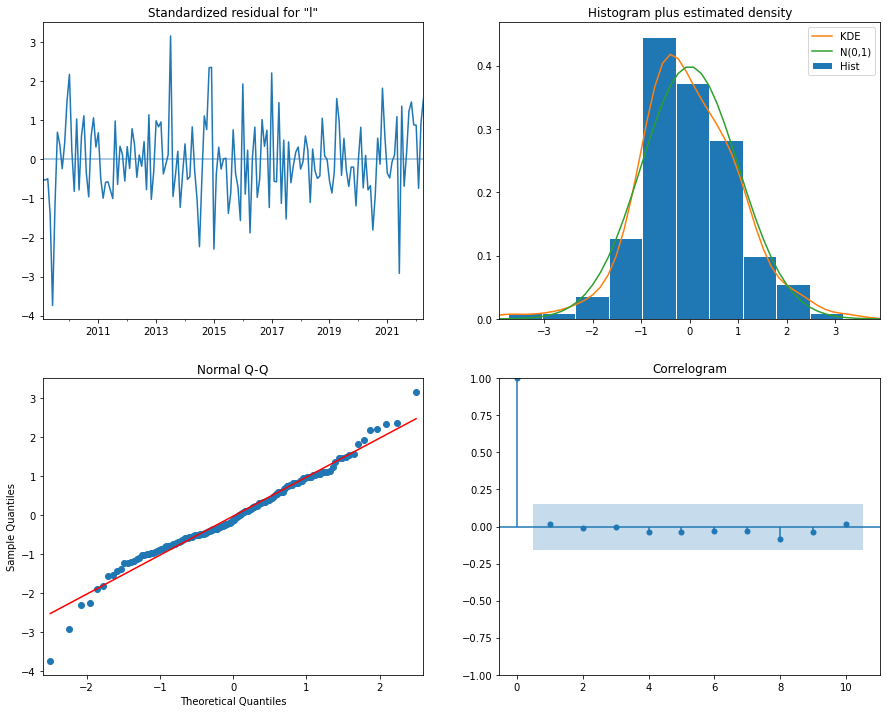

In [27]:
arima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Diagnostic model untuk residual pada ARIMA model:
- Stationary
- Distribusi normal
- Tidak punya dependensi dari eror

In [28]:
arima_model.forecast(steps = 18)

2022-05-01    1.305188
2022-06-01    1.415066
2022-07-01    1.422862
2022-08-01    1.526880
2022-09-01    1.633876
2022-10-01    1.539243
2022-11-01    1.515008
2022-12-01    1.497380
2023-01-01    1.458504
2023-02-01    1.531536
2023-03-01    1.557039
2023-04-01    1.542149
2023-05-01    1.533150
2023-06-01    1.498144
2023-07-01    1.492347
2023-08-01    1.511464
2023-09-01    1.534879
2023-10-01    1.542013
Freq: MS, Name: predicted_mean, dtype: float64

In [29]:
rmse_arima_model = np.sqrt(mse(df_test["inflation"], np.exp(arima_model.forecast(steps = 18))))
rmse_arima_model

1.0799003789029435

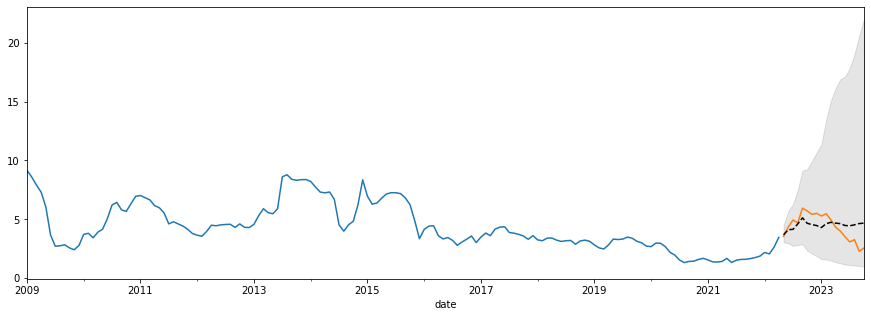

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot data
df_train["inflation"].plot(ax = ax)
df_test["inflation"].plot(ax = ax)

# Plot forecast
fcast = arima_model.get_forecast(steps = 18).summary_frame()
np.exp(fcast['mean']).plot(ax = ax, style='k--')

# Plot conf interval
ax.fill_between(fcast.index, 
                np.exp(fcast['mean_ci_lower']), 
                np.exp(fcast['mean_ci_upper']), color='k', alpha=0.1)
plt.show()

### Cross Validation
---

In [31]:
def cross_validate_arima(X, od_arima, n_fold = 5, test_size = None, gap = 0):
    """
    Function to evaluate RMSE by time series cross-validation.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
        The independent variable or predictors.

    y : {array-like} of shape (n_sample, )
        The dependent or response variable.
        
    n_fold : int
        Number of n_split for TimeSeriesSplit.
        
    test_sizes : int
        Number of test_sizes for TimeSeriesSplit.
        
    gap : int
        Number of gap for TimeSeriesSplit.

    Returns
    -------
    score : float
        The average RMSE score.
    """
    
    # Placeholder for index 
    train_ind_list = []
    valid_ind_list = []
    
    # Define TS Split
    tscv = TimeSeriesSplit(n_splits = n_fold, 
                           test_size = test_size, 
                           gap = gap)
    
    # Get train and valid test index
    for i, (train_index, val_index) in enumerate(tscv.split(X)):
        train_ind_list.append(train_index)
        valid_ind_list.append(val_index)
        
    # Define the number of train sets
    n_split = len(train_ind_list)

    # Initialize RMSE score list for each valid and train set
    score_list_valid = []
    score_list_train = []    
    pred_train = []    
    pred_valid = []    

    for i in range(n_split):
        
        # Extract data from index
        X_train = X.iloc[train_ind_list[i]]
        X_valid = X.iloc[valid_ind_list[i]]

        # Fitting model
        model_arima = ARIMA(X_train, order = od_arima).fit()

        # Get fitted values
        
        start_date = X_valid.index[0]
        end_date = X_valid.index[-1]
        
        X_pred_train = model_arima.fittedvalues
        X_pred_valid = model_arima.predict(start = start_date, 
                                           end = end_date)

        # Calculate RMSE
        rmse_train = np.sqrt(mse(y_true = X_train, y_pred = X_pred_train))
        rmse_valid = np.sqrt(mse(y_true = X_valid, y_pred = X_pred_valid))

        # Append RMSE score in list
        score_list_valid.append(rmse_valid)
        # append RMSE score in list
        score_list_train.append(rmse_train)
        
        
        # Append RMSE score in list
        pred_train.append(X_pred_train)
        # append RMSE score in list
        pred_valid.append(X_pred_valid)
        
        
    # Calculate CV Score
    score_list = pd.DataFrame({"RMSE_train": score_list_train,
                               "RMSE_valid": score_list_valid})
    score_valid = np.mean(score_list_valid)

    return (train_ind_list, 
            valid_ind_list, 
            pred_train,
            pred_valid,
            score_valid, 
            score_list)

In [32]:
# Cek CV function
train_ind_list, valid_ind_list, \
X_pred_train, X_pred_valid, \
validation_set_score, score_folds = cross_validate_arima(X = df_train["inflation"],
                                                         od_arima = (9, 1, 8))

C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aiforesee\AppData\Roaming\Python\P

In [33]:
n_split = len(train_ind_list)
x_train_list = []
x_valid_list = []

for i in range(n_split):        
        x_train_list.append(df_train["inflation"].iloc[train_ind_list[i]])
        x_valid_list.append(df_train["inflation"].iloc[valid_ind_list[i]])

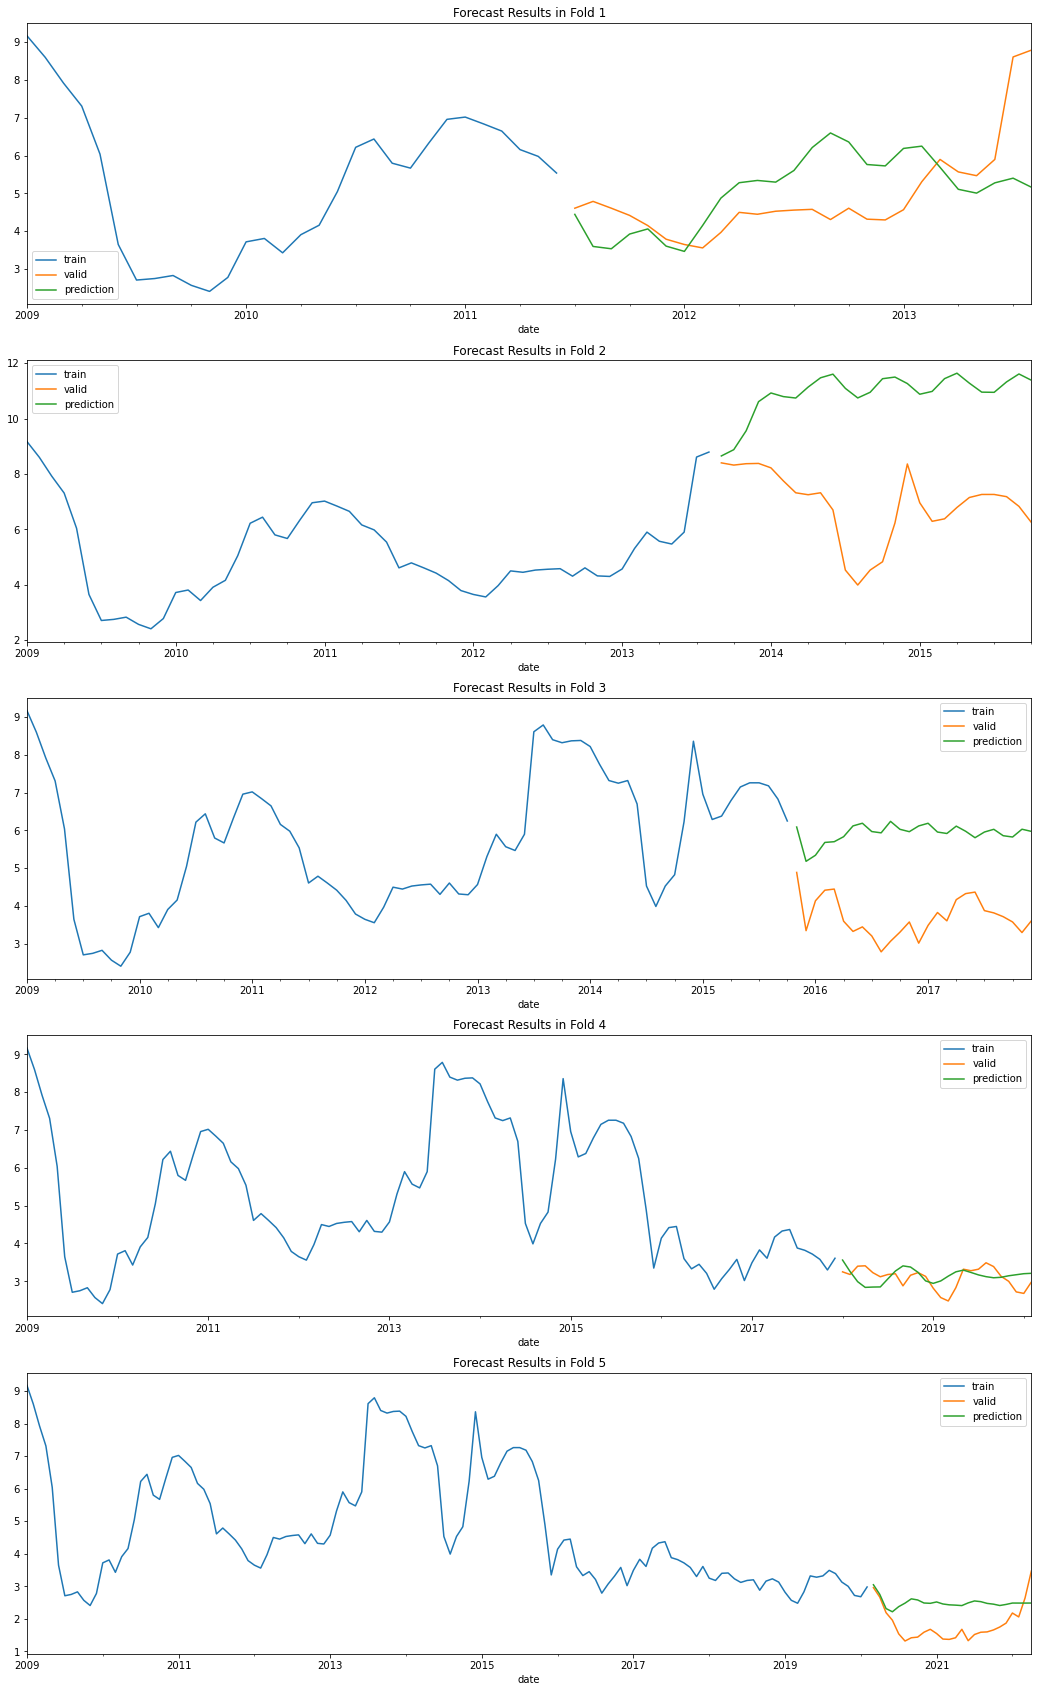

In [57]:
fig, axes = plt.subplots(5,1,
                        figsize=(18, 30))

for i in range(n_split):
    x_train_list[i].plot(ax = axes[i], label = "train", legend = True)
    x_valid_list[i].plot(ax = axes[i], label = "valid", legend = True)
    X_pred_valid[i].plot(ax = axes[i], label = "prediction", legend = True)
    
    axes[i].set_title(f"Forecast Results in Fold {i+1}")
    
    
plt.show()

In [58]:
# RSME pada masing-masing fold

fold_rsme = []
for i in range(len(x_valid_list)):
    fold_rsme.append(np.sqrt(mse(x_valid_list[i], X_pred_valid[i])))
    
folds_rmse = pd.DataFrame({"Fold": [i+1 for i in range(len(fold_rsme))],
                           "RMSE": [fold_rsme[i] for i in range(len(fold_rsme))]})

folds_rmse

,Fold,RMSE
0,1,1.387949
1,2,4.377209
2,3,2.300774
3,4,0.327695
4,5,0.827448


In [59]:
# RSME CV dan train test
summary_score = pd.DataFrame({"Evaluation": ["Cross Validation",
                                             "Train Test Split"],
                              "RMSE": [np.mean(fold_rsme),
                                       rmse_arima_model]})

summary_score

,Evaluation,RMSE
0,Cross Validation,1.844215
1,Train Test Split,1.079900


## Multivariate Time Series Model: VAR
---

### Cointegration
---

Definisi null dan alternative hypothesis ($H_0$ and $H_1$) pada Stationarity test

- $H_0$  : Time Series is Non-Stationary
- $H_1$  : Time Series is Stationary

**1. *Stationarity test - initial variables***

In [37]:
result = adfuller(df['inflation'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[0] < result[4]["5%"]:
    print ("\nReject Ho - Time Series is Stationary")
else:
    print ("\nFailed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.569923
p-value: 0.498682
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576

Failed to Reject Ho - Time Series is Non-Stationary


In [38]:
result = adfuller(df['birate'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[0] < result[4]["5%"]:
    print ("\nReject Ho - Time Series is Stationary")
else:
    print ("\nFailed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.945756
p-value: 0.310851
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576

Failed to Reject Ho - Time Series is Non-Stationary


**2. *Stationarity test - log-transformed variables***

In [39]:
result = adfuller(df['log_inflation'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("\nReject Ho - Time Series is Stationary")
else:
    print ("\nFailed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.604632
p-value: 0.481266
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576

Failed to Reject Ho - Time Series is Non-Stationary


In [40]:
result = adfuller(df['log_birate'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("\nReject Ho - Time Series is Stationary")
else:
    print ("\nFailed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.937808
p-value: 0.314489
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576

Failed to Reject Ho - Time Series is Non-Stationary


**3. *Stationarity test - first-differenced variables***

In [41]:
result = adfuller(df['diff_log_inflation'].dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[0] < result[4]["5%"]:
    print ("\nReject Ho - Time Series is Stationary")
else:
    print ("\nFailed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -5.602417
p-value: 0.000001
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576

Reject Ho - Time Series is Stationary


In [42]:
result = adfuller(df['diff_log_birate'].dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("\nReject Ho - Time Series is Stationary")
else:
    print ("\nFailed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -5.804135
p-value: 0.000000
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576

Reject Ho - Time Series is Stationary


***4. Engle-Granger Test***


Definisi null dan alternative hypothesis ($H_0$ and $H_1$)

- $H_0$  : No cointegration exists
- $H_1$  : Cointegration exists

In [43]:
coint_t, p_val, _ = coint(df['diff_log_birate'].dropna(),
                          df["diff_log_inflation"].dropna(),
                          maxlag=15)

print('p-value: %f' % p_val)

if p_val < 0.05:
    print ("\nReject Ho - Cointegration exists")
else:
    print ("\nFailed to Reject Ho - No cointegration exists")

p-value: 0.000001

Reject Ho - Cointegration exists


In [44]:
coint_t, p_val, _ = coint(df['diff_log_inflation'].dropna(),
                          df["diff_log_birate"].dropna(),
                          maxlag=15)

print('p-value: %f' % p_val)

if p_val < 0.05:
    print ("\nReject Ho - Cointegration exists")
else:
    print ("\nFailed to Reject Ho - No cointegration exists")

p-value: 0.000004

Reject Ho - Cointegration exists


### Var Model
---

In [45]:
# definisi kolom yang akan digunakan pada VAR model
col_to_use = ["diff_log_inflation", "diff_log_birate"]

# Model VAR
model = VAR(df_train[col_to_use].dropna())

# Pada VAR, terdapat function `select_order` untuk train model hingga max lag
x = model.select_order(maxlags=15)
x.summary()

C:\Users\aiforesee\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-11.21,-11.17,1.355e-05,-11.19
1,-11.39*,-11.27*,1.131e-05*,-11.34*
2,-11.37,-11.16,1.157e-05,-11.28
3,-11.33,-11.04,1.205e-05,-11.21
4,-11.29,-10.92,1.252e-05,-11.14
5,-11.26,-10.81,1.285e-05,-11.08
6,-11.23,-10.69,1.328e-05,-11.01
7,-11.19,-10.57,1.378e-05,-10.94
8,-11.23,-10.53,1.328e-05,-10.95
9,-11.20,-10.42,1.369e-05,-10.88


In [46]:
# fit manually the best order to the model
result = model.fit(maxlags = 1)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Jan, 2024
Time:                     20:50:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.2459
Nobs:                     158.000    HQIC:                  -11.3150
Log likelihood:           455.229    FPE:                1.16270e-05
AIC:                     -11.3622    Det(Omega_mle):     1.11977e-05
--------------------------------------------------------------------
Results for equation diff_log_inflation
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.001827         0.009595           -0.190           0.849
L1.diff_log_inflation         0.309964         0.078516            3.948           0.000
L1.diff_log_bir

In [47]:
# Lag order
lag_order = result.k_ar

# Input data untuk forecasting
forecast_input = df_train[col_to_use].values[-lag_order:]

# Forecast
fc = result.forecast(y=forecast_input, steps=nobs_test)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs_test:], columns=col_to_use)

df_forecast

,diff_log_inflation,diff_log_birate
date,,
2022-05-01,0.082909,0.007830
2022-06-01,0.025862,0.003364
2022-07-01,0.007044,-0.000587
2022-08-01,0.000207,-0.002841
2022-09-01,-0.002485,-0.003975
2022-10-01,-0.003608,-0.004515
2022-11-01,-0.004094,-0.004767
2022-12-01,-0.004308,-0.004882
2023-01-01,-0.004404,-0.004935


In [48]:
# Invert transformation untuk memperoleh real forecast
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = ["inflation", "birate"]
    for col in columns:        
        df_fc[col] = np.exp(df_train['log_'+str(col)].iloc[-1] + df_fc['diff_log_'+str(col)].cumsum())
    return df_fc

df_results = invert_transformation(df_train, df_forecast)        
df_results

,diff_log_inflation,diff_log_birate,inflation,birate
date,,,,
2022-05-01,0.082909,0.007830,3.769958,3.527514
2022-06-01,0.025862,0.003364,3.868729,3.539401
2022-07-01,0.007044,-0.000587,3.896078,3.537324
2022-08-01,0.000207,-0.002841,3.896884,3.527288
2022-09-01,-0.002485,-0.003975,3.887210,3.513296
2022-10-01,-0.003608,-0.004515,3.873210,3.497469
2022-11-01,-0.004094,-0.004767,3.857387,3.480838
2022-12-01,-0.004308,-0.004882,3.840806,3.463885
2023-01-01,-0.004404,-0.004935,3.823929,3.446834


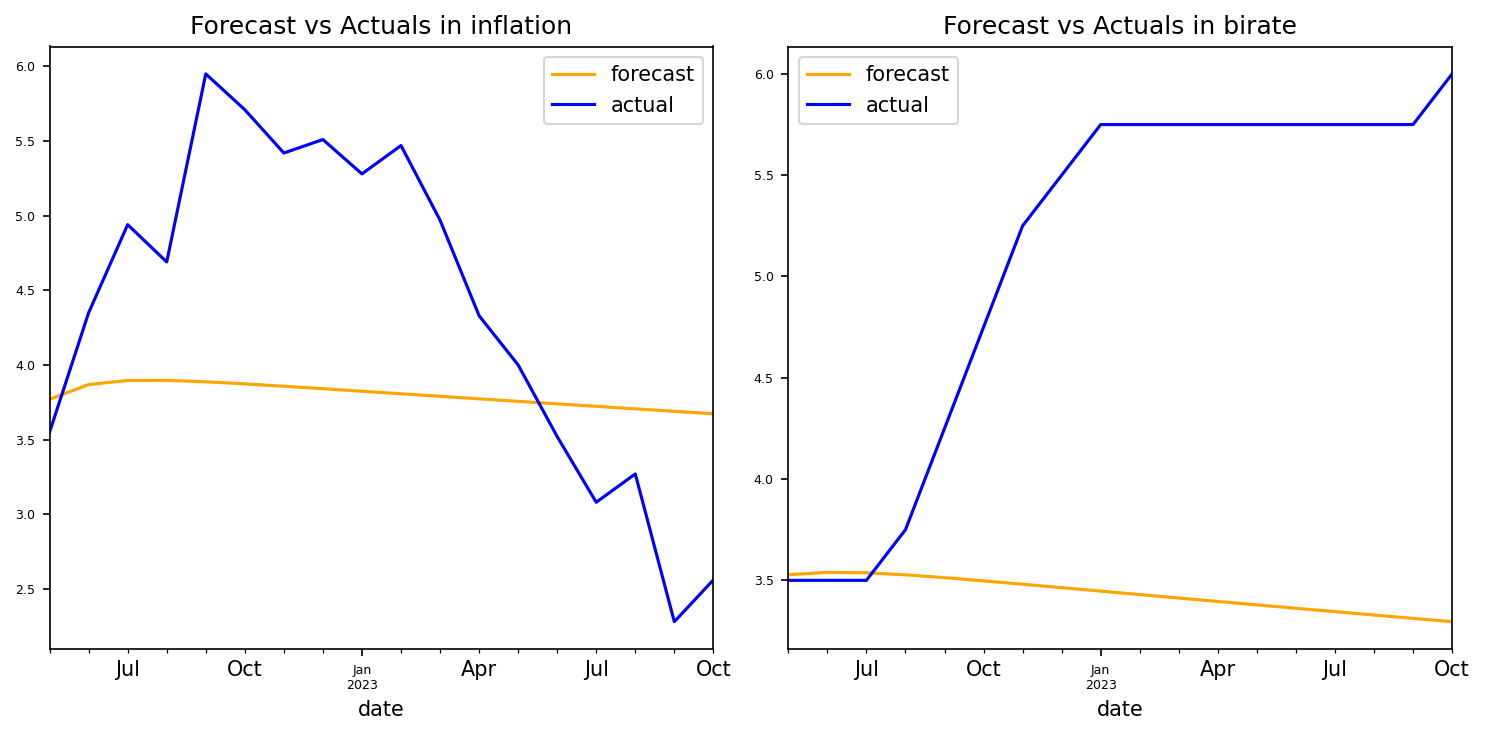

In [49]:
col_to_use = ["inflation", "birate"]

fig, axes = plt.subplots(nrows=int(len(col_to_use)/2), 
                         ncols=2, 
                         dpi=150, 
                         figsize=(10,5))


for i, (col,ax) in enumerate(zip(col_to_use, axes.flatten())):
    df_results[col].plot(legend=True, ax = ax, 
                         color = "orange", label = "forecast").autoscale(axis='x',tight=True)
    
    df_test[col][-nobs_test:].plot(legend = True, ax = ax,
                                   color = "b", label = "actual");
    
    ax.set_title("Forecast vs Actuals in " + col)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [50]:
rmse_var_inf = np.sqrt(mse(df_test["inflation"], df_results["inflation"]))
rmse_var_birate = np.sqrt(mse(df_test["birate"], df_results["birate"]))

print(f"RMSE from Inflation forecast = {rmse_var_inf}")
print(f"RMSE from BI Rate forecast = {rmse_var_birate}")

RMSE from Inflation forecast = 1.1874387712348347
RMSE from BI Rate forecast = 1.9343938829752083


# Best Model

In [51]:
print(f"RMSE from Inflation forecast with")
print(f"Naive model = %f" % rmse_naive_model)
print(f"ARIMA model = %f" % rmse_arima_model)
print(f"VAR model   = %f" % rmse_var_inf)

RMSE from Inflation forecast with
Naive model = 1.424929
ARIMA model = 1.079900
VAR model   = 1.187439


Berdasarkan RMSE, model terbaik yang memiliki RMSE terkecil yaitu **ARIMA MODEL**

In [52]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          log_inflation   No. Observations:                  160
Model:                 ARIMA(9, 1, 8)   Log Likelihood                 135.484
Date:                Fri, 05 Jan 2024   AIC                           -234.968
Time:                        20:50:40   BIC                           -179.728
Sample:                    01-01-2009   HQIC                          -212.536
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4428      0.136      3.261      0.001       0.177       0.709
ar.L2         -0.2091      0.187     -1.119      0.263      -0.575       0.157
ar.L3          0.0383      0.203      0.189      0.850      -0.360       0.436
ar.L4         -0.9163      0.154     -5.951      0.000      -1.218      -0.614
ar.L5          0.4293      0.192      2.236      0.025       0.053       0.806
ar.L6         -0.1398      0.183     -0.763      0.446      -0.499       0.219
ar.L7          0.0717      0.163      0.441      0.659      -0.247       0.391
ar.L8         -0.3566      0.139     -2.566      0.010      -0.629      -0.084
ar.L9          0.1311      0.113      1.155      0.248      -0.091       0.353
ma.L1         -0.1183      0.215     -0.549      0.583      -0.540       0.304
ma.L2          0.0676      0.170      0.399      0.690      -0.265       0.400
ma.L3          0.0005      0.254      0.002      0.999      -0.497       0.498
ma.L4          1.2077      0.205      5.904      0.000       0.807       1.609
ma.L5          0.0125      0.252      0.050      0.960      -0.481       0.506
ma.L6          0.0067      0.157      0.043      0.966      -0.300       0.313
ma.L7         -0.0184      0.179     -0.103      0.918      -0.369       0.332
ma.L8          0.8954      0.281      3.185      0.001       0.344       1.447
sigma2         0.0099      0.003      3.729      0.000       0.005       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                10.59
Prob(Q):                              0.83   Prob(JB):                         0.01
Heteroskedasticity (H):               0.93   Skew:                            -0.04
Prob(H) (two-sided):                  0.79   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

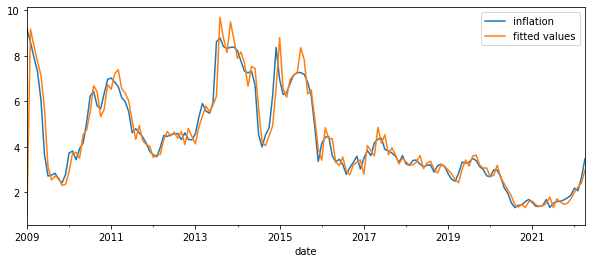

In [53]:
df_train["inflation"].plot(figsize = (10,4), legend = True)
np.exp(arima_model.fittedvalues).plot(figsize = (10,4), label = "fitted values", legend = True)

plt.show()

# References
---


- https://www.bps.go.id/id/statistics-table/1/OTE1IzE=/tingkat-inflasi-tahun-ke-tahun-gabungan-90-kota--sup-1--sup---2018-100-.html
- https://www.bps.go.id/id/statistics-table/2/Mzc5IzI=/bi-rate.html
- https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
https://www.bps.go.id/id/statistics-table/1/OTE1IzE=/tingkat-inflasi-tahun-ke-tahun-gabungan-90-kota--sup-1--sup---2018-100-.html
https://www.bps.go.id/id/statistics-table/2/Mzc5IzI=/bi-rate.html
https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/\
- James D. Hamilton. Time Series Analysis
- George Athanasopoulos and Rob J. Hyndman. Forecasting: Principles and Practice
- Jonathan Cryer and Kung-sik Chan. Time Series Analysis: With Application in R